[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W1D4_Paleoclimate/W1D4_Tutorial5.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/{ORG}/course-content/main/tutorials/W1D4_Paleoclimate/W1D4_Tutorial5.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# **Tutorial 5: Paleoclimate Data Analysis Tools**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Yosmely Bermúdez, Dionessa Biton, Katrina Dobson, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Brodie Pearson, Jenna Pearson, Chi Zhang, Ohad Zivan 

**Content editors:** Yosmely Bermúdez, Zahra Khodakaramimaghsoud, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepming

# **Tutorial Objectives**

In this tutorial, you will explore various computational analyses for interpreting paleoclimate data and understand why these methods are useful. A common issue in paleoclimate is the presence of uneven time spacing between consecutive observations. `Pyleoclim` includes several methods that can deal with uneven sampling effectively, but there are certain applications and analyses for which it's ncessary to place the records on a uniform time axis. In this tutorial you'll learn a few ways to do this with `Pyleoclim`. Additionally, we will explore another useful paleoclimate data analysis tool, Principal Component Analysis (PCA), which allows us to identify a common signal between various paleoclimate reconstructions. 

By the end of this tutorial you'll be able to perform the following data analysis techniques on proxy-based climate reconstructions:

*   Interpolation
*   Binning 
*   Principal component analysis


# Setup

In [1]:
# imports
import pandas as pd
import cartopy
import pyleoclim as pyleo
import matplotlib.pyplot as plt
import pooch
import os
import tempfile

In [2]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

In [3]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/tutorials/W1D4_Paleoclimate' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

# **Section 1: Load the sample dataset for analysis**

For this tutorial, we are going to use an example dataset to practice the various data analysis techniques. The dataset we'll be using is a record of hydrogen isotopes of leaf waxes (δD<sub>wax</sub>) from Lake Tanganyika in East Africa [(Tierney et al., 2008)](https://www.science.org/doi/10.1126/science.1160485?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed). Recall from the video that δD<sub>wax</sub> is a proxy that is typically thought to record changes in the amount of precipitation in the tropics via the amount effect. In the previous tutorial, we looked at δD data from high-latitude ice cores. In that case, δD was a proxy for temperature, but in the tropics, δD more commonly reflects rainfall amount, as explained in the introductory video.

Let's first read the data from a .csv file.

In [4]:
filename_tang='tanganyika_dD.csv'
url_tang = "https://osf.io/sujvp/download/"
tang_dD = pd.read_csv(pooch_load(filelocation=url_tang,filename=filename_tang))
tang_dD.head()

,Age,dD,dD_IVbio,dD_IVonly,d13C
0,1405,-105.2,-15.6,-105.1,-31.4
1,1769,-97.3,-6.9,-97.2,-30.7
2,1997,-93.7,-2.8,-93.5,-30.4
3,2316,-107.8,-18.5,-107.8,-29.8
4,2545,-103.1,-13.5,-103.2,-30.4


We can now create a `Series` in Pyleoclim and assign names to different variables so that we can easily plot the data.

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [yr BP]', ylabel='dDwax [per mille]'>)

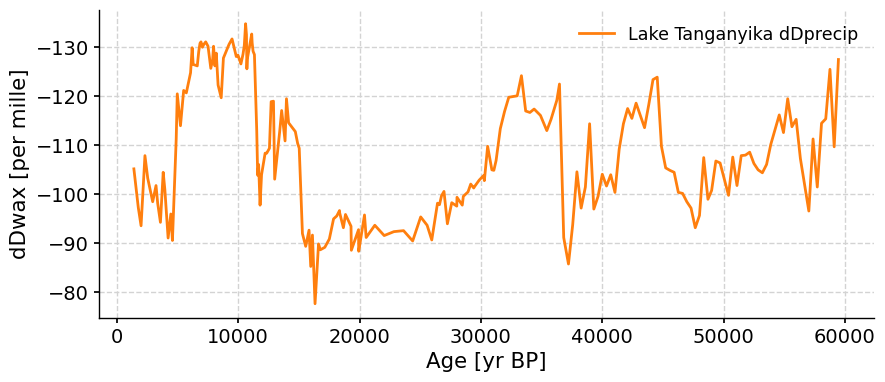

In [5]:
ts_tang = pyleo.Series(
    time=tang_dD['Age'],
    value= tang_dD['dD_IVonly'],
    time_name='Age',
    time_unit='yr BP',
    value_name='dDwax',
    value_unit='per mille',
    label='Lake Tanganyika dDprecip'
)

ts_tang.plot(color='C1',invert_yaxis=True)

You may notice that the y-axis is inverted. When we're plotting δD data, we typically invert the y-axis because more negative ("depleted") values suggest increased rainfall, whereas more positive ("enriched") values suggest decreased rainfall.

# **Section 2: Uniform Time-Sampling of the Data**
There are a number of different reasons we might want to assign new values to our data. For example, if the data is not evenly spaced, we might need to resample in order to use a sepcific data analysis technique or to more easily compare to other data of a different sampling resolution. 

First, let's check whether our data is already evenly spaced using the `.is_evenly_spaced()` method:

In [6]:
ts_tang.is_evenly_spaced()

False

Our data is not evenly spaced. There are a few different methods available in `pyleoclim` to place the data on a uniform axis, and in this tutorial, we'll explore two methods: interpolating and binning. In general, these methods use the available data near a chosen time to estimate what the value was at that time, but each method differs in which nearby data points it uses and how it uses them.


## **Section 2.1: Interpolation**
To start out, let's try using interpolation to evenly space our data. Interpolation projects the data onto an evenly spaced time axis with a distance between points (step size) of our choosing. There are a variety of different methods by which the data can be interpolated, these being: `linear`, `nearest`, `zero`, `slinear`, `quadratic`, `cubic`, `previous`, and `next`. More on these and their associated key word arguments can be found in the [documentation](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.interp). By default, the function `.interp()` implements linear interpolation:

In [7]:
tang_linear = ts_tang.interp() # default method = 'linear'

In [8]:
# check whether or not the series is now evenly spaced
tang_linear.is_evenly_spaced()

True

Now that we've interpolated our data, let's compare the original dataset to the linearly interpolated dataset we just created.

<Axes: xlabel='Age [yr BP]', ylabel='dDwax [per mille]'>

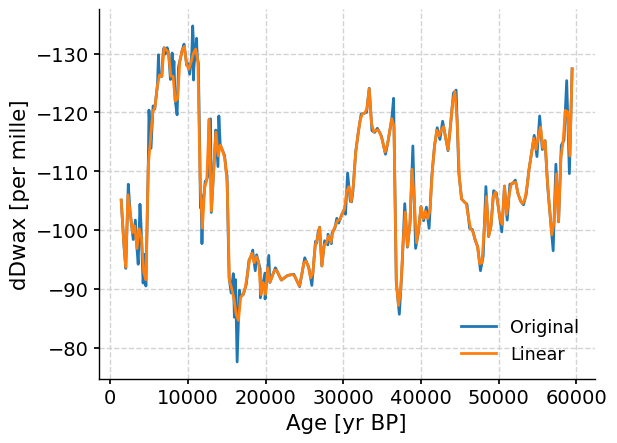

In [9]:
fig,ax=plt.subplots() # assign a new plot axis
ts_tang.plot(ax=ax, label='Original', invert_yaxis=True)
tang_linear.plot(ax=ax, label='Linear')

Notice there are only some minor differences between the original and linearly interpolated data.

You can print the data in the original and interpolated time series to see the difference in the ages between the two datasets. The interpolated dataset is now evenly spaced with a δD value every ~290 years.

In [10]:
ts_tang

{'label': 'Lake Tanganyika dDprecip'}


None
Age [yr BP]
1405.0    -105.1
1769.0     -97.2
1997.0     -93.5
2316.0    -107.8
2545.0    -103.2
           ...  
58061.0   -114.4
58409.0   -115.3
58757.0   -125.4
59105.0   -109.6
59454.0   -127.4
Name: dDwax [per mille], Length: 201, dtype: float64

In [11]:
tang_linear

{'label': 'Lake Tanganyika dDprecip'}


None
Age [yr BP]
1405.000    -105.100000
1695.245     -98.800727
1985.490     -93.686785
2275.735    -105.995017
2565.980    -102.954380
                ...    
58293.020   -115.000052
58583.265   -120.357691
58873.510   -120.110178
59163.755   -112.596673
59454.000   -127.400000
Name: dDwax [per mille], Length: 201, dtype: float64

Let's compare a few of the different interpolation methods (e.g., quadratic, next, zero) with one another just to see how they are similar and different:

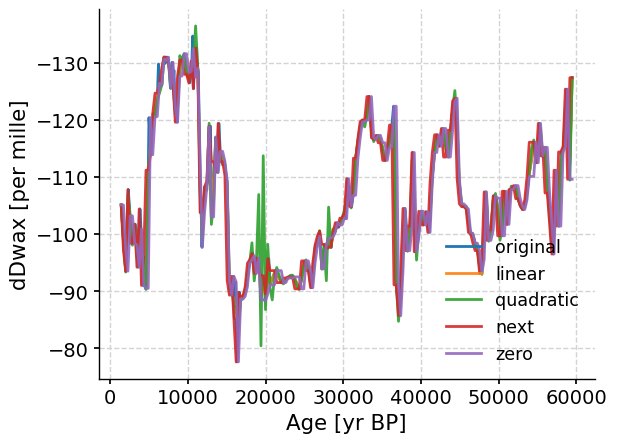

In [12]:
fig,ax=plt.subplots() # assign a new plot axis
ts_tang.plot(ax=ax,label='original', invert_yaxis=True)
for method in ['linear','quadratic','next','zero']:
    ts_tang.interp(method=method).plot(ax=ax,label=method,alpha=0.9) # plot all the method we want

The methods can produce slightly different results, but mostly reproduce the same overall trend. In this case, the quadractic method may be less appropriate than the other methods.

## **Section 2.2: Binning**
Another option for resampling our data onto a uniform time axis is binning. Binning is when a set of time intervals is defined and data is grouped or binned with other data in the same interval, then all those points in a "bin" are averaged to get a data value for that bin. The defaults for binning pick a bin size at the coarsest time spacing present in the dataset and average data over a uniform sequence of such intervals. 

In [13]:
tang_bin = ts_tang.bin() #default settings pick the coarsest time spacing in the data as the binning period

<Axes: xlabel='Age [yr BP]', ylabel='dDwax [per mille]'>

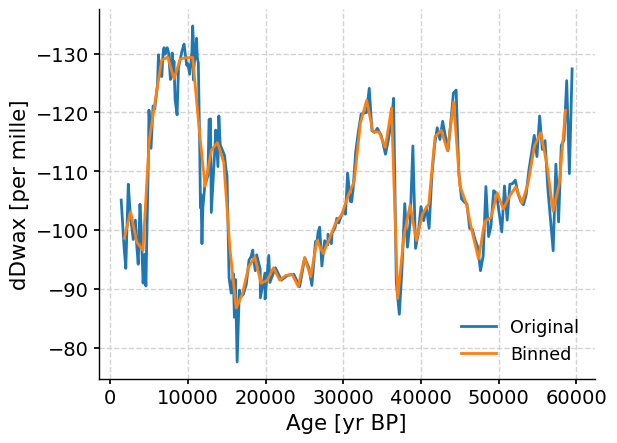

In [14]:
fig,ax=plt.subplots() # assign a new plot axis
ts_tang.plot(ax=ax,label='Original',invert_yaxis=True)
tang_bin.plot(ax=ax,label='Binned')

Again, notice that although there are some minor differences between the original and binned data, the records still capture the same overall trend.

## **Coding Exercises 2.2**


1. Experiment with different bin sizes to see how this affects the resampling. You can do so by adding  `bin_size = ` to `ts_tang.bin()`. Try a bin size of 500 years and 1,000 years and plot both of them on the same graph as the original data and the binned data using the default bin size.

In [16]:
# bin size of 500
tang_bin_500 = ...

# bin size of 1000
tang_bin_1000 = ...

# plot
_ = ...
_ = ...
_ = ...
_ = ...
_ = ...

/srv/conda/envs/notebook/lib/python3.10/site-packages/pyleoclim/core/series.py:3887: UserWarning: no_nans is set to True but nans are present in the series. It has likely been overridden by other parameters. See tsutils.bin() documentation for details on parameter hierarchy
  res_dict = tsutils.bin(self.time,self.value,**kwargs)


<Axes: xlabel='Age [yr BP]', ylabel='dDwax [per mille]'>

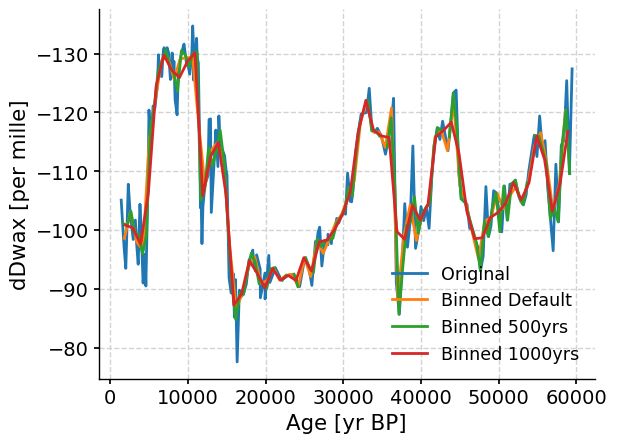

In [15]:
# to_remove solution

# bin size of 500
tang_bin_500 = ts_tang.bin(bin_size = 500)

# bin size of 1000
tang_bin_1000 = ts_tang.bin(bin_size = 1000)

# plot
fig,ax=plt.subplots() # assign a new plot axis
ts_tang.plot(ax=ax,label='Original',invert_yaxis=True)
tang_bin.plot(ax=ax,label='Binned Default')
tang_bin_500.plot(ax=ax,label='Binned 500yrs')
tang_bin_1000.plot(ax=ax,label='Binned 1000yrs')

# **Section 3: Principal Component Analysis (PCA)**
Large datasets, such as global climate datasets, are often difficult to interpret due to their multiple dimensions. Although tools such as Xarray help us to organize large, multidimensional climate datasets, it can still sometimes be difficult to interpret certain aspects of such data. Principal Component Analysis (PCA) is a tool for reducing the dimensionality of such datasets and  increasing interpretability with minimal modification or loss of data. In other words, PCA allows us to reduce the number of variables of a dataset, while preserving as much information as possible.

The first step in PCA is to calculate a matrix that summarizes how the variables in a dataset all relate to one another. This matrix is then broken down into new uncorrelated variables that are linear combinations or mixtures of the initial variables. These new variables are the **principal components**. The initial dimensions of the dataset determines the number of principal components calculated. Most of the information within the initial variables is compressed into the first components. Additional details about PCA and the calculations involved can be found [here](https://builtin.com/data-science/step-step-explanation-principal-component-analysis).

Applied to paleoclimate, PCA can reduce the dimensionality of large paleoclimate datasets with multiple variables and can help us identify a common signal between various paleoclimate reconstructions. An example of a study that applies PCA to paleoclimate is [Otto-Bliesner et al., 2014](https://www.science.org/doi/full/10.1126/science.1259531). This study applies PCA to rainfall reconstructions from models and proxies from throughout Africa to determine common climate signals in these reconstructions.

In this section, we will calculate the PCA of four δD paleoclimate records from Africa to assess common climate signals in the four records.  In order to calculate the PCA of multiple paleoclimate time series, all of the records need to be on a common time-step. To do so, we can apply the resampling tools we've learned in this tutorial.

So far, we've been looking at δD data from Lake Tanganyika in tropical East Africa. Let's compare this δD record to other existing δD records from lake and marine sediment cores in tropical Africa from the Gulf of Aden [(Tierney and deMenocal, 2017)](https://doi.org/10.1126/science.1240411), Lake Bosumtwi [(Shanahan et al., 2015)](https://doi.org/10.1038/ngeo2329), and the West African Margin [(Tierney et al., 2017)](https://doi.org/10.1126/sciadv.1601503).

First, let's load these datasets:

In [16]:
# Gulf of Aden
filename_aden='aden_dD.csv'
url_aden = "https://osf.io/gm2v9/download/"
aden_dD = pd.read_csv( pooch_load(filelocation=url_aden,filename=filename_aden))
aden_dD.head()

,depth_cm,age_calBP95-,age_calBP,age_calBP95+,dDwax,dDwaxIVcorr
0,1.25,-21,0,23,-128.9,-128.9
1,7.50,105,138,170,-128.3,-128.3
2,11.50,183,226,265,-133.6,-133.6
3,16.50,279,335,383,-133.6,-133.6
4,21.50,376,442,500,-138.1,-138.1


In [17]:
# Lake Bosumtwi
filename_Bosumtwi='bosumtwi_dD.csv'
url_Bosumtwi = "https://osf.io/mr7d9/download/"
bosumtwi_dD = pd.read_csv(pooch_load(filelocation=url_Bosumtwi,filename=filename_Bosumtwi))
bosumtwi_dD.head()

,age_calBP,d13CleafwaxC31,d2HleafwaxC31ivc
0,68.8162,-28.40,-19.463969
1,217.1656,-30.12,-19.605047
2,360.0397,-31.00,-12.654186
3,404.7102,-28.90,-15.056285
4,488.1144,-29.94,-13.752030


In [18]:
# GC27 (West African Margin)
filename_GC27='gc27_dD.csv'
url_GC27 = "https://osf.io/k6e3a/download/"
gc27_dD = pd.read_csv(pooch_load(filelocation=url_GC27,filename=filename_GC27))
gc27_dD.head()

,depth_cm,age_BP,dDwax,dDwax_iv,d13Cwax,dDP
0,2.5,867,-130.2,-130.2,-30.64,-16.6
1,5.5,1345,-135.3,-135.2,-31.13,-22.8
2,9.5,2133,-131.7,-131.6,-30.85,-18.6
3,11.5,2535,-131.9,-131.9,-30.33,-18.1
4,14.5,3141,-132.1,-132.3,-30.07,-18.3


Next, let's convert each dataset into a `Series` in Pyleoclim.

In [19]:
ts_tanganyika = pyleo.Series(
    time=tang_dD['Age'],
    value= tang_dD['dD_IVonly'],
    time_name='Age',
    time_unit='yr BP',
    value_name='dDwax',
    label='Lake Tanganyika'
)
ts_aden = pyleo.Series(
    time=aden_dD['age_calBP'],
    value= aden_dD['dDwaxIVcorr'],
    time_name='Age',
    time_unit='yr BP',
    value_name='dDwax',
    label='Gulf of Aden'
)
ts_bosumtwi = pyleo.Series(
    time=bosumtwi_dD['age_calBP'],
    value=bosumtwi_dD['d2HleafwaxC31ivc'],
    time_name='Age',
    time_unit='yr BP',
    value_name = 'dDwax',
    label='Lake Bosumtwi'
)
ts_gc27 = pyleo.Series(
    time=gc27_dD['age_BP'],
    value=gc27_dD['dDwax_iv'],
    time_name='Age',
    time_unit='yr BP',
    value_name='dDwax',
    label='GC27'
)

Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order


Now let's set up a `MultipleSeries` using Pyleoclim with all four δD datasets. 

In [20]:
ts_list = [ts_tanganyika, ts_aden, ts_bosumtwi, ts_gc27]
ms_africa = pyleo.MultipleSeries(ts_list, label='African dDwax')

We can now create a stackplot with all four δD records:

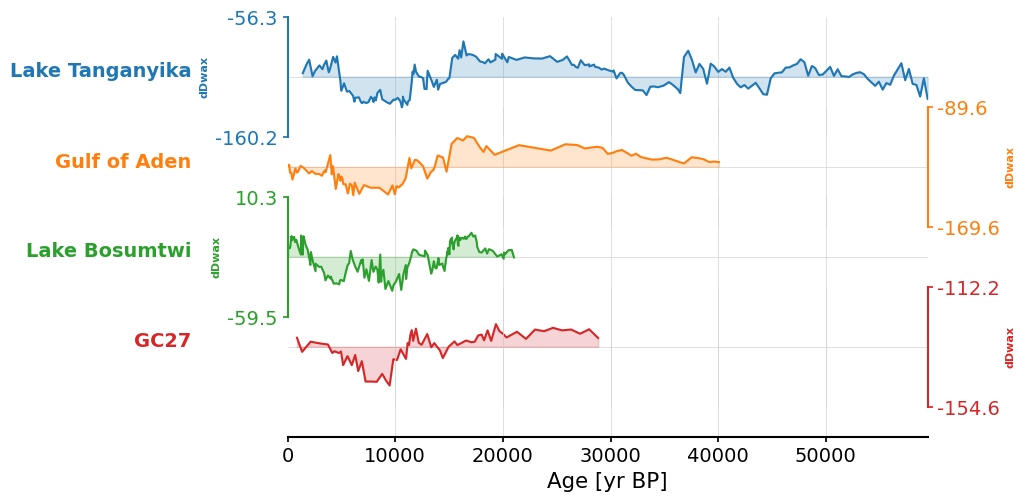

In [21]:
fig, ax = ms_africa.stackplot()

By creating a stackplot, we can visually compare between the datasets. However, the four δD records aren't the same resolution and don't span the same time interval.

To better compare the records and assess a common trend, we can use PCA. First, we can use [`.common_time()`] to place the records on a shared time axis with a common sampling frequency. This function takes the argument `method`, which can be either `bin`, `interp`, and `gdkernel`. The binning and interpolation methods are what we just covered in the previous section. Let's set the time step to 500 years, the method to `interp`, and standarize the data:

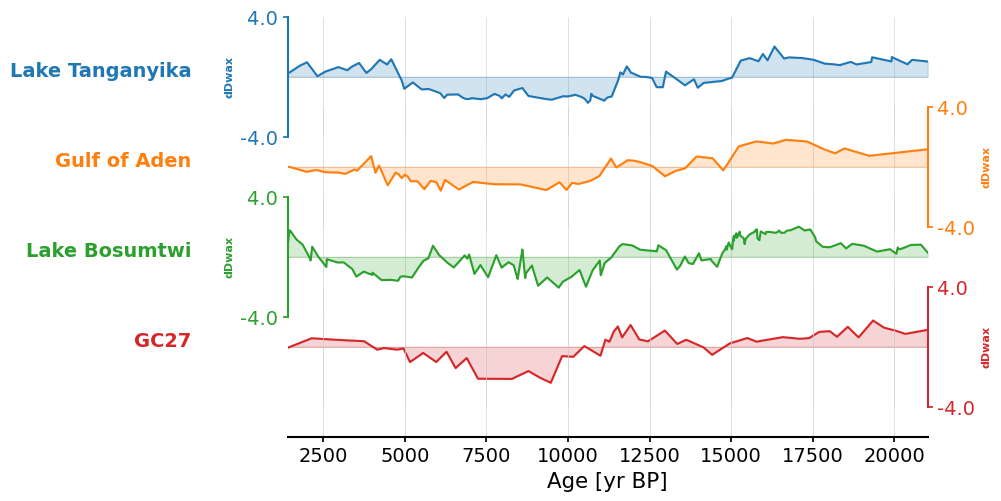

In [22]:
africa_ct = ms_africa.common_time(method = 'interp',step=0.5).standardize()
fig, ax = africa_ct.stackplot()

We now have standardized δD records that are the same sampling resolution and span the same time interval. Note this meant trimming the longer time series down to around 20,000 years in length.

We can now apply PCA which will allow us to quantitatively identify a common signal between the four δD paleoclimate reconstructions through the [`.pca`](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.multipleseries.MultipleSeries.pca) method. Note that this line of code may take a few minutes to run.

In [ ]:
africa_PCA = africa_ct.pca()

The result is an object containing multiple outputs, and with two plotting methods attached to it. The two outputs we'll look at are pctvar (the variance) and pcs (the principal components). 

First, let's print the percentage of variance accounted for by each mode, which is saved as pctvar:

In [ ]:
print(africa_PCA.pctvar.round())

This means that 97% of the variance in the four paleoclimate records is explained by the first principal component. The number of datasets in the PCA constrains the number of principal components that can be defined, which is why we only have four components in this example.

We can now look at the principal component of the first mode of variance. Let's create a new series for the first mode of variance and plot it against the original datasets:

In [ ]:
africa_pc1 = africa_PCA.pcs

In [ ]:
africa_mode1 = pyleo.Series(
    time=africa_ct.series_list[0].time,
    value=africa_PCA.pcs[:,0],
    label=r'$PC_1$',
    value_name='PC1',
    time_name ='age',
    time_unit = 'yr BP'
)

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_ylabel('dDwax')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('PC1')  # we already handled the x-label with ax1

#plt.plot(mode1.time,pc1_scaled)
africa_mode1.plot(color='black', ax=ax2, invert_yaxis=True)
africa_ct.plot(ax=ax1, linewidth=0.5)

The original δD records are shown in the colored lines, and the first principal component (PC1) time series is shown in black. 

## **Questions 3: Climate Connection**
 

1.   How do the original time series compare to the PC1 time series? Do they record similar trends?
2.   Which original δD record most closely resembles the PC1 time series? Which is the most different?
3.   What changes in climate does the PC1 time series record over the past 20,000 years? *Hint: remember that more depleted (more negative) δD suggests increased rainfall.*

In [ ]:
# to_remove explanation

"""
1. The overall trends are similar. However, there is more variability in the original δD records than in the PC1 time series. This makes sense because the principal component analysis identifies a common signal between original δD reconstructions and therefore is inherently less variable.
2. The Gulf of Aden δD record is the most similar to the PC1 time series. The Lake Bosumtwi δD record is the least similar to the PC1 time series. This difference is particularly noticeable between 5,000-10,000 years ago.
3. The PC1 time series suggests a drier climate (more positive δD) in Africa over the past 20,000 years. Recall that 20,000 years ago was the last glacial period. African rainfall increased ~15,000 years ago during the deglacial transition. There is a short period of drying ~12,000 years ago, which corresponds to the timing of the Younger Dryas (a millennial-scale, Northern Hemisphere high-latitude cooling event). This is followed by an increase in rainfall associated with what is known as the African Humid Period (a period of wet, humid conditions in northern and equatorial Africa, driven by intensification of the African monsoon). Finally, there is a decrease in rainfall over the past ~8,000 years towards the present. Note: δD only records qualitative changes in rainfall (i.e., wetter or drier relative to another time period), and does not provide quantitative measurements of the amount of rainfall.
""";

# **Summary**
In this tutorial, you explored a variety of computational techniques for analyzing paleoclimate data. You learned how to handle irregular data and place these records on a uniform time axis using interpolation and binning. 

You then explored Principal Component Analysis (PCA), a method that reveals common signals across various paleoclimate reconstructions. To effectively utilize PCA, it's essential to have all records on the same sampling resolution and same time-step, which can be achieved using the resampling tools you learned in this tutorial.

For your practical example, we used a dataset of hydrogen isotopes of leaf waxes (δD<sub>wax</sub>) from Lake Tanganyika in East Africa to further enhance your understanding of the discussed techniques, equipping you to better analyze and understand the complexities of paleoclimate data.

# **Resources**

Code for this tutorial is based on existing notebooks from LinkedEarth for [anlayzing LiPD datasets](https://github.com/LinkedEarth/paleoHackathon/blob/main/notebooks/PaleoHack-nb03_EDA.ipynb) and [resampling data with `Pyleoclim`](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L1_uniform_time_sampling.ipynb).

Data from the following sources are used in this tutorial:

*   Tierney, J.E., et al. 2008. Northern Hemisphere Controls on Tropical Southeast African Climate During the Past 60,000 Years. Science, Vol. 322, No. 5899, pp. 252-255, 10 October 2008. https://doi.org/10.1126/science.1160485.
*   Tierney, J.E., and deMenocal, P.. 2013. Abrupt Shifts in Horn of Africa Hydroclimate Since the Last Glacial Maximum. Science, 342(6160), 843-846. https://doi.org/10.1126/science.1240411.
*   Tierney, J.E., Pausata, F., deMenocal, P. 2017. Rainfall Regimes of the Green Sahara. Science Advances, 3(1), e1601503. https://doi.org/10.1126/sciadv.1601503. 
*   Shanahan, T.M., et al. 2015. The time-transgressive termination of the African Humid Period. Nature Geoscience, 8(2), 140-144. https://doi.org/10.1038/ngeo2329.